# Atividade 02
### Análise Estatística e Exploratória dos Dados
**Discente:** Danne Makleyston Gomes Pereira <br>
**Disciplina:** Introdução à Ciência de Dados

In [2]:
!pip install plotly -q
!pip install unidecode -q 
!pip install wordcloud -q
!pip install numerize -q

In [3]:
import pandas as pd
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt
%matplotlib inline
import ipywidgets as widgets
from scipy.stats import norm
from scipy import stats
from collections import Counter
from unidecode import unidecode
from urllib.request import urlopen, urlretrieve
from PIL import Image
import requests
import json
import math
from numerize import numerize
import plotly.figure_factory as ff
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
py.init_notebook_mode(connected=True)
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Loading do Dataset Cultura Cearense

In [4]:
df_dataset = pd.read_csv('../dt.csv', sep='\t', lineterminator='\n')

In [5]:
# Formatando os dados
df_dataset['amount_registers'] = df_dataset['amount_registers'].apply(lambda d: int(np.nan_to_num(d))) 
df_dataset['city'] = df_dataset['city'].apply(lambda d: d.upper() if d is not np.nan else d)
df_dataset['project_title'] = df_dataset['project_title'].apply(lambda d: d.upper() if d is not np.nan else d)
df_dataset['title'] = df_dataset['title'].apply(lambda d: d.upper() if d is not np.nan else d)
df_dataset['bidder'] = df_dataset['bidder'].apply(lambda d: d.upper() if d is not np.nan else d)
df_dataset['city'] = df_dataset['city'].apply(lambda d: unidecode(d) if d is not np.nan else d)

In [8]:
df_pop = pd.read_csv('../popce.csv', sep='\t', lineterminator='\n')
df_pop.columns = ['uf', 'cod_uf', 'cod_municipio', 'municipio', 'populacao']
df_pop['municipio'] = df_pop['municipio'].apply(lambda d: d.upper() if d is not np.nan else d)
df_pop['municipio'] = df_pop['municipio'].apply(lambda d: unidecode(d) if d is not np.nan else d)
df_pop['populacao'] = df_pop['populacao'].apply(lambda d: int(d.replace(".","")))

In [ ]:
# Convertendo os valores monetários para Decimal
# df_dataset['value'] = df_dataset['value'].apply(lambda d: Decimal(d))
# df_bkp = df_dataset.copy()

### Análise dos dados

**Dados estatísticos do DataFrame**

Com esse dataset podemos analisar diversos investimentos realizados no estado do Ceará por meio do governo mediante editais de fomento, publicado no site da [secretaria da Cultura do Ceará](https://www.secult.ce.gov.br/). 

Vamos realizar algumas análises para um melhor entendimento no tocante aos apliques financeiros realizados pela gestão do estado. Para tanto, resolvemos, inicialmente, verificar se há *outliers*. 

#### 1. Média, mediana, *outliers* 

In [10]:
notices_value_gb = df_dataset.groupby(by=['order'], dropna=True)['value'].max()

min_   = notices_value_gb.min()
max_   = notices_value_gb.max()
mean_  = notices_value_gb.mean()
std_   = notices_value_gb.std()
median_ = notices_value_gb.median()

print("O menor valor investido: ", min_)
print("O maior valor investido: ", max_)
print("A média dos valores: ", mean_)
print("O desvio padrão: ", std_)
print("A mediana dos valores: ", median_)


O menor valor investido:  0.0
O maior valor investido:  26700000.0
A média dos valores:  2737623.814032258
O desvio padrão:  6085277.858051023
A mediana dos valores:  556900.0


#### 1.1. Média, mediana, *outliers*  apenas dos editais com recursos financeiros

In [11]:
notices_value_ = df_dataset[df_dataset['value'] > 0]
notices_value_gb = notices_value_.groupby(by=['order'], dropna=True)['value'].max()

min_   = notices_value_gb.min()
max_   = notices_value_gb.max()
mean_  = notices_value_gb.mean()
std_   = notices_value_gb.std()
median_ = notices_value_gb.median()

print("O menor valor investido: ", min_)
print("O maior valor investido: ", max_)
print("A média dos valores: ", mean_)
print("O desvio padrão: ", std_)
print("A mediana dos valores: ", median_)


O menor valor investido:  11760.0
O maior valor investido:  26700000.0
A média dos valores:  3202503.3296226417
O desvio padrão:  6474746.444060744
A mediana dos valores:  781596.0


**Encontrando *outliers***

In [24]:
# Listando os outliers
value_outliers_z_score_ = []
value_outliers_z_score_scipy_ = []
value_outliers_interquartile_ = []

value_outliers_z_score_ = find_outliers_z_score(notices_value_gb)
value_outliers_z_score_scipy_ = find_outliers_scipy(notices_value_gb)
value_outliers_interquartile_ = find_outliers_interquartile(notices_value_gb)

print('z-score: ', value_outliers_z_score_)
print('z-score: ', value_outliers_z_score_scipy_)
print('interqualite: ', value_outliers_interquartile_)

z-score:  [26000000.0, 26700000.0, 26000000.0]
z-score:  [26000000.0, 26700000.0, 26000000.0]
interqualite:  [8200000.0, 11500000.0, 17800000.0, 26000000.0, 26000000.0, 26700000.0]


#### Primeiros *outliers*
<img src="image/outliers01.png">
<img src="image/outliers02.png">
<img src="image/outliers05.png">
<!-- <img src="image/outliers03.png">
<img src="image/outliers04.png"> -->


***Outlier* corrigido**

**Boxplot corrigido**

In [25]:
def show_boxplot_values(d):
    _values = d.groupby(by=['order'])['value'].max()
    _boxplot_values = _values.rename('Fomento (R$)')

    return px.box(_boxplot_values, y="Fomento (R$)", 
                title='Valores fomentados via editais', width=400, height=600)

show_boxplot_values(notices_value_)

**Histograma**

In [26]:
def show_hist(series, b, outliers):
    _hist = series[~series.isin(outliers)]
    _hist = _hist.sort_values()
    fig = px.histogram(_hist, nbins=b, 
                      labels={'top':'Editais de fomento', 
                              'count':'Quantidade de editais', 
                              '_value':'Investimento (R$)'},
                      title='Distribuição', width=600, height=400)
    return fig.show()

show_hist(notices_value_gb, 100, [])

**Entendendo os *outliers***

In [27]:
# Título do edital que obteve o maior investimento financeiro
def get_outliers(d):
    return d[d['value'].isin(value_outliers_interquartile_)].groupby(by=['order'])[['title']]

get_outliers(df_dataset).max()

,title
order,
5,XIV EDITAL CEARÁ CINEMA E VÍDEO
7,XIII EDITAL MECENAS DO CEARÁ
10,EDITAL DE APOIO AO AUDIOVISUAL CEARENSE – LEI ...
15,PRÊMIO FOMENTO CULTURA E ARTE DO CEARÁ – LEI A...
36,XI EDITAL MECENAS DO CEARÁ – 2018
38,XII EDITAL MECENAS DO CEARÁ – 2019


In [28]:
def outliers_notices_year(d, outliers):
    _dates = d[d['value'].isin(outliers)].groupby(by=['order'])['registration_date_init'].max()
    _years = []
    for date in _dates:
        if date is not np.nan:
            _years.append(int(get_year(date)))
    return _years

outliers_notices_year(df_dataset, value_outliers_interquartile_)

[2019, 2021, 2020, 2020, 2018, 2019]

In [29]:
# Barchart
def barchart_outliers(outliers):
    _years = outliers_notices_year(df_dataset, outliers)
    _years.sort()
    _k_years = Counter(_years).keys()
    _v_freq = Counter(_years).values()

    _df = pd.DataFrame({'Ano':_k_years, 'Quantidade':_v_freq})
    _df['Ano'] = _df['Ano'].apply(lambda d: str(d))

    fig = px.bar(_df, x='Ano', y='Quantidade', title='Outliers: publicações por ano', width=500, height=400)
    fig.update_yaxes(dtick='1', tickformat="d")
    return fig.show()
    
barchart_outliers(value_outliers_interquartile_)

### Visualização dos dados

**Qual relação entre quantidade de inscritos, quantidade de projetos a serem aprovados e valor investido por edital?**

In [37]:
def rel_registers_value(d):
    d = d[d['amount_registers'] > 0]
    _d_gb = d.groupby(by=['order'])[['amount_registers', 'order', 'title', 'value']]
    _df = _d_gb.max()
    _df['number_of_approved_projects'] = list(_d_gb.count()['order'])
    _df['rel'] =  _df['amount_registers'] / _df['number_of_approved_projects']
    _df['value_log'] = _df['value'].apply(lambda d: np.log10(d))
    
    fig = px.scatter(_df, x="number_of_approved_projects", y="amount_registers", 
                     size='rel', 
                     color='value_log', 
                     color_continuous_scale="Viridis",
                     labels={'amount_registers':'Qtd. inscritos', 
                             'number_of_approved_projects':'Qtd. proj. aprovados', 
                             'rel': 'Concorrência', 'value':'Investimento'},
                     width=800,height=500,
                     opacity=0.7,
                     hover_name='title',
                     hover_data={'value_log':False,
                                 'value':True},
                      title='Valor investido por quantidade de editais publicados por mês'
                     )
    fig.add_shape(type="line",
        x0=-50, y0=-50, x1=_df["amount_registers"].max(), y1=_df["amount_registers"].max(),
        line=dict(
            color="MediumPurple",
            width=2,
            dash="dot",
        )
    )
    
    _tickvals = list(np.arange(round(_df['value_log'].min()), round(_df['value_log'].max())+1, 0.5))
    _ticktext = [numerize.numerize(10 ** i) for i in _tickvals]
    
    fig.update_layout(
        xaxis = dict(
            tickmode = 'linear',
            dtick = 100
        ),
        coloraxis_colorbar=dict(
                                title="Inv. (R$)",
                                thicknessmode="pixels", thickness=50,
                                yanchor="top", y=1,
                                ticks="outside",
                                dtick=0.1,
                                ticktext=_ticktext,
                                tickvals=_tickvals
                            )
    )
    
    _df_top_10 = _df.sort_values(by=['rel'], ascending = False)[0:10]
    _df_top_10['title_wrapped'] = _df_top_10['title'].apply(lambda d: d[0:20] + '...')
    
    fig_bar = px.bar(
        _df_top_10, 
        x='title', 
        y=['amount_registers','number_of_approved_projects'],
        color_discrete_map={
            'amount_registers': 'rgb(55, 83, 109)',
            'number_of_approved_projects': 'rgb(26, 118, 255)'
        },
        barmode="group",
        labels={
            'title_wrapped':'Título',
            'title':'Título',
            'amount_registers':'Qtd. inscrições',
            'number_of_approved_projects':'Qtd. proj. aprovados',
            '_value':'Quantiadade'
        },
        title='Top 10: Editais com maiores concorrência',
#         hover_name='title',
        hover_data={'title_wrapped':False,
                    'title':True},
        
    )
    
    fig_bar.update_layout(
        uniformtext_minsize=8, 
        uniformtext_mode='hide',
        xaxis_tickangle=-45,
        xaxis = dict(
            tickmode = 'array',
            tickvals = [i for i in range(0, 10)],
            ticktext = _df_top_10['title_wrapped']
        )
    )
    
    _df_table = _df_top_10[['title_wrapped', 'amount_registers', 'number_of_approved_projects', 'value', 'rel']]
    _df_table['rel'] = _df_table['rel'].apply(lambda d: '{:.2f}'.format(d))
    _df_table['value'] = _df_table['value'].apply(lambda d: numerize.numerize(d))
    _df_table.columns = ['Título','Qtd. inscrições','Qtd. proj. aprovados', 'R$','Concorrência']

    fig_table = ff.create_table(_df_table)
    
    fig.show()
    fig_bar.show()
    fig_table.show()
    
rel_registers_value(notices_value_)

**Quantos editais foram publicados nos últimos anos?**

In [38]:
def number_of_notices_per_year(d, outliers):
    _year = notice_year(d, outliers)
    _year.sort()
    _k_year = Counter(_year).keys()
    _v_freq = Counter(_year).values()
    _df = pd.DataFrame({'Ano':_k_year, 'Quantidade':_v_freq})
    fig = px.bar(_df, x='Ano', y='Quantidade', title='Quantidade de editais por ano', width=600, height=500)
    return fig.show()
    
number_of_notices_per_year(df_dataset, [])

**Quanto foi investido em projetos culturais, por meio de editais, nos últimos anos?**

In [39]:
def investiment_per_year(d):
    _df_value_without_nan = d[d['value'].notna()]
    _df_year_value = _df_value_without_nan.groupby(by=['order'])[['year','value']].max()
    
    _v_per_y = _df_year_value.groupby(by=['year'])[['value']].sum()

    _ind = list()
    for i in range(len(_v_per_y.index)):
        _ind.append(str(_v_per_y.index[i]))

    _new_df = pd.DataFrame({'year':(_ind), 'value':_v_per_y['value']})
    fig = px.bar(_new_df, x='year', y='value', title='Total investido por ano', 
                labels={'year':'Anos', 'value':'Total investido (R$)'},
                text='value', width=600, height=500)
    fig.update_traces(texttemplate='%{text:.3s}', textposition='outside')
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
    
    return fig.show()    
    
investiment_per_year(df_dataset)

**Quantidade de editais e valor investido por ano**

In [40]:
def scale(val, src, dst):
    return ((val - src[0]) / (src[1]-src[0])) * (dst[1]-dst[0]) + dst[0]

In [41]:
def barchart_investiment_and_number_of_notices_per_year(d):
    
    _df_value_without_nan = d[d['value'].notna()]
    _df_year_value = _df_value_without_nan.groupby(by=['order'])[['year','value']].max()
    
    _v_per_y = _df_year_value.groupby(by=['year'])[['value']].sum()

    _ind = list()
    for i in range(len(_v_per_y.index)):
        _ind.append(str(_v_per_y.index[i]))

    _df_investiment = pd.DataFrame({'year':(_ind), 'value':_v_per_y['value']})

    _years = notice_year(d, [])
    _years.sort()
    _k_year = Counter(_years).keys()
    _v_freq = Counter(_years).values()
    _df_number_of_notices = pd.DataFrame({'year':_k_year, 'number':_v_freq})
    
    _df_result = pd.concat([_df_number_of_notices.set_index('year'), _df_investiment], axis=1, join="inner")
    
    fig = px.bar(_df_result, x='year', y='number', title='Totais de editais e investimento por ano', 
                labels={'year':'Investimento por ano', 'value':'Total investido (R$)',
                        'number':'Quantidade de editais'},
                text='value', width=600, height=500)
    fig.update_traces(texttemplate='%{text:.3s}', textposition='outside')
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
    
    _df_result['avg'] = _df_result['value']/_df_result['number']
    _df_result['avg_1'] = _df_result['avg'].apply(
        lambda d: scale(d, [_df_result['avg'].min(), _df_result['avg'].max()], [2, 20]))
#     _df_result['avg'] = _df_result['avg'].apply(lambda d: numerize.numerize(str(d)))
    
    fig_s = make_subplots(rows=1, cols=2, 
                       subplot_titles=("Relação: Valor investido por quantidade de editais publicados por ano", 
                                       "Relação: Valor investido por quantidade de editais publicados por mês"))
    
    
    fig2 = px.scatter(_df_result, x="number", y="value", color='year',
                     size='avg_1', 
                     labels={'year':'Anos', 'value':'Investimento', 
                             'number': 'Quantidade de editais',
                             'avg':'Média de inestimento por edital'}
                     ,width=600,height=500,
                     opacity=0.9,
                     hover_name='year',
                     hover_data={'year':False,'avg':True},
                      title='Valor investido por quantidade de editais publicados por ano'
                     )
    
    # Month init
    _df_value_without_nan['month'] = _df_value_without_nan['registration_date_init'].apply(lambda d: d[3:5])
    _df_month_value = _df_value_without_nan.groupby(by=['order'])[['month','value']].max()
    
    _v_per_m = _df_month_value.groupby(by=['month'])[['value']].sum()

    _ind = list()
    for i in range(len(_v_per_m.index)):
        _ind.append(str(_v_per_m.index[i]))

    _df_investiment = pd.DataFrame({'month':(_ind), 'value':_v_per_m['value']})

    _months = notice_month(d, [])
    _months.sort()
    _k_month = Counter(_months).keys()
    _v_freq = Counter(_months).values()
    _df_number_of_notices = pd.DataFrame({'month':_k_month, 'number':_v_freq})
    _df_result_month = pd.concat([_df_number_of_notices.set_index('month'), _df_investiment], axis=1, join="inner")
    _df_result_month['avg'] = _df_result_month['value']/_df_result_month['number']
    
    _df_result_month['avg_2'] = _df_result_month['avg'].apply(
        lambda d: scale(d, [_df_result_month['avg'].min(), _df_result_month['avg'].max()], [1, 10]))
    
    # Month end
    
#     print( _df_result_month )
    fig3 = px.scatter(_df_result_month, x="number", y="value", color='month',
                     size='avg_2', 
                     labels={'year':'Anos', 'value':'Investimento', 
                             'number': 'Quantidade de editais',
                             'avg':'Média de inestimento por edital',
                             'month':'Mês'}
                     ,width=600,height=500,
                     opacity=0.9,
                     hover_name='month',
                     hover_data={'month':False,'avg':True},
                      title='Valor investido por quantidade de editais publicados por mês'
                     )
    fig3.update_layout(
        xaxis = dict(
            tickmode = 'linear',
            dtick = 1
        )
    )


    fig.show()    
    fig2.show()
    fig3.show()
    
barchart_investiment_and_number_of_notices_per_year(df_dataset)

**Quantidade de editais e valor investido por mês**

In [42]:
def barchart_investiment_and_number_of_notices_per_year4(d):
    
    _df_value_without_nan = d[d['value'].notna()]
    _df_year_value = _df_value_without_nan.groupby(by=['order'])[['year','value']].max()
    
    _v_per_y = _df_year_value.groupby(by=['year'])[['value']].sum()

    _ind = list()
    for i in range(len(_v_per_y.index)):
        _ind.append(str(_v_per_y.index[i]))

    _df_investiment = pd.DataFrame({'year':(_ind), 'value':_v_per_y['value']})

    _years = notice_year(d, [])
    _years.sort()
    _k_year = Counter(_years).keys()
    _v_freq = Counter(_years).values()
    _df_number_of_notices = pd.DataFrame({'year':_k_year, 'number':_v_freq})
    
    _df_result = pd.concat([_df_number_of_notices.set_index('year'), _df_investiment], axis=1, join="inner")
    
    fig = make_subplots(rows=1, cols=2, 
                       subplot_titles=("Total investido por ano", "Quantidade de editais por ano", "Relação Investimento/Editais"))
    
    fig.add_bar(y=_df_result['value']*1., 
                x=_df_result['year'], 
                text=_df_result['value'], 
                row=1, col=1,
                cliponaxis=False,
                name='Total investido').update_traces(
                    texttemplate='%{text:.3s}', 
                    textposition='outside')
    
    fig.add_bar(y=_df_result['number'], 
                x=_df_result['year'], 
                text=_df_result['number'], 
                row=1, col=2,
                cliponaxis=False,
                name='Quantidade de editais').update_traces(
                     textposition='outside')
    
    _rel = _df_result['value'] / _df_result['number']
 

    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', width=900, height=400, 
                     margin=dict(l=10, r=20, t=100, b=0),
                     legend=dict(
                        orientation="h",
                        yanchor="top",
                        y=-0.15,
                        xanchor="right",
                        x=1
                    ))
    
    fig2 = go.Figure(data=go.Scatter(x=_df_result['year'], y=_rel,
                        mode='lines+markers+text',
                        text=_rel,
                        textposition="bottom center",
                        texttemplate = "%{text:.3s}",
                        name='Relação Investimento/Editais'))
    
    fig2.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', width=900, height=400, 
                     margin=dict(l=10, r=20, t=30, b=0),
                     title="Média de investimento (R$) por edital por ano",
                     legend=dict(
                        orientation="h",
                        yanchor="top",
                        y=-0.15,
                        xanchor="right",
                        x=1
                    ))

    fig.show(), fig2.show()    

barchart_investiment_and_number_of_notices_per_year4(df_dataset)

In [43]:
def show_boxplot_values_month(d):
    d['month'] = d['registration_date_init'].apply(lambda d: d[3:5])
    _values_gb = d.groupby(by=['month','order'])
    _df_m = pd.DataFrame({'value':_values_gb['value'].max(), 'month_':_values_gb['month'].max()})
    
    _total_month = _df_m.groupby(by=['month_'])['value'].sum()

    _series_line = _df_m.groupby(by=['month_']).count()
    _series_line['month_'] = _series_line.index
    _series_line.columns = ['amount', 'month_']
    _series_line['AVG'] = _total_month / _series_line['amount']  

    fig_sub = make_subplots(rows=1, cols=2, 
                       subplot_titles=("Valores fomentados via editais", "Fomento por mês"))
    
    fig_sub.add_trace(go.Box(x=_df_m["month_"],
                            y=_df_m["value"]))
    
#     fig_sub.add_box( 
#         y=_df_m["value"], 
#         x=_df_m["month_"], 
#         row=1,
#         col=1)
    
    fig2 = px.line(_series_line, x='month_', y='AVG', 
                   labels={'amount':'Quantidade de editais',
                           'month_':'Mês'},
                   hover_data={'amount':True})
    fig_sub.add_bar(
        x=_df_m['month_'], 
        y=_df_m['value'], 
        row=1,
        col=2)
    
    fig_sub.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', width=900, height=400, 
                     margin=dict(l=10, r=20, t=100, b=0),
                     legend=dict(
                        orientation="h",
                        yanchor="top",
                        y=-0.15,
                        xanchor="right",
                        x=1
                    ))
    
    fig_sub.show()
    fig2.show()


show_boxplot_values_month(df_dataset)

**Qual cidade teve mais projetos aprovados em editais de fomento à cultura?**

In [44]:
with urlopen('https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-23-mun.json') as response:
    cities_json_ = json.load(response)
    
for i in range(len(cities_json_['features'])):
    cities_json_['features'][i]['properties']['name'] = unidecode(cities_json_['features'][i]['properties']['name'].upper())

In [45]:
def notice_per_city(d, year_filter):
    
    d, year_filter = filtred_dataset(d, year_filter)
    
    _city_gp = d.groupby(by=['city'])['city']
    _cities = _city_gp.count().sort_values().index
    _values = _city_gp.count().sort_values().values
    
    return pd.DataFrame({'city':_cities, 'amount':_values}), year_filter

In [46]:
notice_per_city(df_dataset, 2021)[0][-5:]

,city,amount
117,MARACANAU,24
118,CRATO,27
119,CAUCAIA,31
120,JUAZEIRO DO NORTE,75
121,FORTALEZA,499


In [47]:
def choroplethmap_notice_per_city(d, year_filter):

    d['amount_log'] = d['amount'].apply(lambda d: np.log2(d))

    year_filter = str(year_filter)
    
    fig = px.choropleth_mapbox(d, geojson=cities_json_, locations='city', color='amount_log',
                               color_continuous_scale="Blues",#["white", "blue"],
                               featureidkey="properties.name",
                               range_color=(d['amount_log'].min(), d['amount_log'].max()),
                               mapbox_style="carto-positron",
                               zoom=6, center = {"lat": -5.1814679, "lon": -39.2140467},
                               opacity=1,
                               labels={'amount_log':'Projetos<br>(log)',
                                      'amount':'Quantidade'},
                               hover_name="city", hover_data={
                                   'amount_log':False,
                                   'city':False,
                                   'amount':True},
                               title='Mapa do Ceará com a quantidade de projetos aprovados por cidades (' + year_filter + ')'
                              )
 
    _tickvals = list(range(int(d['amount_log'].min()), int(d['amount_log'].max())+1))
    _ticktext = [(2 ** i) for i in _tickvals]
    
    fig.update_layout(margin={"r":0,"t":60,"l":0,"b":0}, 
                             coloraxis_colorbar=dict(
                                title="Qtd. Editais",
                                thicknessmode="pixels", thickness=50,
                                yanchor="top", y=1,
                                ticks="outside",
                                dtick=1,
                                ticktext=_ticktext,
                                tickvals=_tickvals
                            ))
    
    
    _df_pop = df_pop.copy()
    _df_result = pd.concat([d.set_index('city'), _df_pop.set_index('municipio')], axis=1, join="inner")
    _df_result['city'] = _df_result.index
    _df_result['number_approved_register_per_hundred_thousand'] = _df_result['amount'].values / _df_result['populacao'].values * 100000
    _df_result['number_approved_register_per_hundred_thousand_log'] = _df_result['number_approved_register_per_hundred_thousand'].apply(lambda d: np.log2(float(d)) )
    _df_result['number_approved_register_per_hundred_thousand'] = _df_result['number_approved_register_per_hundred_thousand'].apply(lambda d: '{:.2f}'.format(d) )
    
    fig_pop = px.choropleth_mapbox(_df_result, geojson=cities_json_, locations='city', color='number_approved_register_per_hundred_thousand_log',
                               color_continuous_scale="Blues",
                               featureidkey="properties.name",
                               range_color=(_df_result['number_approved_register_per_hundred_thousand_log'].min(), _df_result['number_approved_register_per_hundred_thousand_log'].max()),
                               mapbox_style="carto-positron",
                               zoom=6, center = {"lat": -5.1814679, "lon": -39.2140467},
                               opacity=1,
                               labels={'number_approved_register_per_hundred_thousand_log':'Projetos<br>(log)',
                                      'number_approved_register_per_hundred_thousand':'Quantidade'},
                               hover_name="city", hover_data={
                                   'number_approved_register_per_hundred_thousand_log':False,
                                   'city':False,
                                   'number_approved_register_per_hundred_thousand':True},
                               title='Mapa do Ceará com a quantidade de projetos aprovados por cidades por 100.000 habitantes (' + year_filter + ')'
                              )
    
    
    _tickvals = list(range(int(_df_result['number_approved_register_per_hundred_thousand_log'].min()), 
                           int(_df_result['number_approved_register_per_hundred_thousand_log'].max() + 1)))
    _ticktext = [(2 ** i) for i in _tickvals]
    
    fig_pop.update_layout(margin={"r":0,"t":60,"l":0,"b":0}, 
                             coloraxis_colorbar=dict(
                                title="Qtd. Editais",
                                thicknessmode="pixels", thickness=50,
                                yanchor="top", y=1,
                                ticks="outside",
                                dtick=1,
                                ticktext=_ticktext,
                                tickvals=_tickvals
                            ))
    

    _df_top_10 = _df_result#[_df_result['populacao'] >= 30000]
    _df_top_10['number_approved_register_per_hundred_thousand'] = _df_top_10['number_approved_register_per_hundred_thousand'].apply(lambda d: pd.to_numeric(d))
    _df_top_10 = _df_top_10.sort_values(by=['number_approved_register_per_hundred_thousand'], ascending=False)
    _df_top_10 = _df_top_10[:10]
   
    _df_table = _df_top_10[['city', 'amount', 'number_approved_register_per_hundred_thousand', 'populacao']]
    _df_table.columns = ['Cidade','Qtd de projetos aprov.','Qtd. projs. aprov. (100.000 h)', 'População']

    fig_table = ff.create_table(_df_table)
    
    fig.show()
    fig_pop.show()
    fig_table.show()
    
def choroplethmap_notice_per_city_parser(year_filter):
    d, year_filter = notice_per_city(df_dataset, year_filter)
    return choroplethmap_notice_per_city(d, year_filter)

def filter_of_choroplethmap_notice_per_city():
    _s = get_slider_year()
    display(_s)
    _out = widgets.interactive_output(choroplethmap_notice_per_city_parser, {'year_filter':_s})
    display(_out)
    
filter_of_choroplethmap_notice_per_city()

SelectionSlider(continuous_update=False, description='Ano:', index=5, options=(2017, 2018, 2019, 2020, 2021, '…

Output()

In [49]:
def barchart_notice_per_city(d, year_filter):
    
    df_cities, year_filter = notice_per_city(d, year_filter)
    
    _total = df_cities['amount'].sum()
    _top = 10
    df_cities['percentage'] = df_cities['amount'].apply(lambda d: '{:.2f}%'.format(d / _total * 100))
    _colors = ['lightslategray',] * _top

    for i in range(1, 4):
        _colors[_top-i] = 'crimson'
    
    _df_cities = df_cities.sort_values(by=['amount'], ascending=True)[-1 * _top:]
    fig = go.Figure(go.Bar(
            x = _df_cities['amount'],
            y = _df_cities['city'],
            orientation = 'h',
            text = _df_cities['percentage'],
            marker_color = _colors
    ))
    fig.update_layout(title='TOP 3: Cidades com mais projetos aprovados (' + str(year_filter) + ')')
    
    _df_pop = df_pop.copy()
    _df_result = pd.concat([df_cities.set_index('city'), _df_pop.set_index('municipio')], axis=1, join="inner")
    _df_result['city'] = _df_result.index
    _df_result['number_approved_register_per_hundred_thousand'] = _df_result['amount'].values / _df_result['populacao'].values * 100000
    _df_result['number_approved_register_per_hundred_thousand'] = _df_result['number_approved_register_per_hundred_thousand'].apply(lambda d: round(d) )
    _df_result = _df_result.sort_values(by=['number_approved_register_per_hundred_thousand'], ascending=True)[-1 * _top:]
    
    fig2 = go.Figure(go.Bar(
            x = _df_result['number_approved_register_per_hundred_thousand'],
            y = _df_result['city'],
            orientation = 'h',
            text = _df_result['number_approved_register_per_hundred_thousand'],
            marker_color = _colors
    ))
    fig2.update_layout(title='TOP 3: Cidades com mais projetos aprovados por 100.000 habitantes (' + str(year_filter) + ')')
    
    fig.show()
    fig2.show()
    
# barchart_notice_per_city(df_dataset, '2021')

In [50]:
def barchart_notice_per_city_with_filter_parser(year_filter):
    return barchart_notice_per_city(df_dataset, year_filter)

def filter_of_barchart_notice_per_city():
    _s = get_slider_year()
    display(_s)
    _out = widgets.interactive_output(barchart_notice_per_city_with_filter_parser, {'year_filter':_s})
    display(_out)

filter_of_barchart_notice_per_city()

SelectionSlider(continuous_update=False, description='Ano:', index=5, options=(2017, 2018, 2019, 2020, 2021, '…

Output()

**Quanto foi aplicado em cada cidade para fomento à cultura, por meio de editais, nos últimos anos?**

In [51]:
def get_investimento_by_approved_projects_by_city(d):
    d_value_gp = d.groupby(by=['order'])[['value']]
    _value_per_project_per_notice = d_value_gp.max() / d_value_gp.count()
    _approved_projects = d[~d['project_title'].isna()].groupby(by=['order','city'])[['city']].count()['city']
    _idx = _approved_projects.index
    _values = _approved_projects.values

    _total_value_by_city = list()
    for i in range(len(_idx)):
        _total_value_by_city.append( {'city': _idx[i][1], 
                                      'total_value': (_values[i] * _value_per_project_per_notice.loc[_idx[i][0]]).value,
                                      'number_of_registers': _values[i]} )
        
    return pd.DataFrame( _total_value_by_city )
        

get_investimento_by_approved_projects_by_city(df_dataset)

,city,total_value,number_of_registers
0,ACARAU,14228.571429,3
1,ACOPIARA,14228.571429,3
2,AIUABA,4742.857143,1
3,ALTO SANTO,18971.428571,4
4,APUIARES,14228.571429,3
...,...,...,...
932,ITAPIPOCA,31250.000000,1
933,MONSENHOR TABOSA,125000.000000,4
934,NOVO ORIENTE,31250.000000,1
935,PORANGA,31250.000000,1


In [52]:
def barchart_investiment_by_city(d, year_filter):
    
    d, year_filter = filtred_dataset(d, year_filter)
    year_filter = str(year_filter)
    
    _cities_gb = get_investimento_by_approved_projects_by_city(d).groupby(by=['city']).sum().sort_values(by=['total_value'])
    _cities_gb['city'] = _cities_gb.index
    _total_all_cities = _cities_gb.sum()
    
    _top = 10    
    _colors = ['lightslategray',] * _top
     
    _percentage = _cities_gb['total_value'] / _total_all_cities['total_value'] * 100
    _percentage = _percentage[-1 * _top:]
    _percentage = _percentage.apply(lambda d: '{:.2f}%'.format(d))

    for i in range(1,4):
        _colors[_top - i] = 'crimson'
    
    _cities_gb = _cities_gb[-1 * _top:]
    fig = go.Figure(go.Bar(
            x=_cities_gb['total_value'],
            y=_cities_gb.index,
            orientation='h',
            text=_percentage,
            marker_color=_colors
    ))
    fig.update_layout(title='TOP 3: Cidades com maiores recebimento de fomento (R$) (' + year_filter + ')')
    
#     return _cities_gb.head()
#     _df_pop = df_pop.copy()
#     _df_result = pd.concat([_cities_gb.set_index('city'), _df_pop.set_index('municipio')], axis=1, join="inner")
#     _df_result['city'] = _df_result.index
#     _df_result['investimento_per_hundred_thousand'] = _df_result['total_value'].values / _df_result['populacao'].values * 100000
#     _df_result['investimento_per_hundred_thousand'] = _df_result['investimento_per_hundred_thousand'].apply(lambda d: round(d) )
#     _df_result = _df_result.sort_values(by=['investimento_per_hundred_thousand'], ascending=True)[-1 * _top:]
    
#     return _df_result
#     fig2 = go.Figure(go.Bar(
#             x = _df_result['investimento_per_hundred_thousand'],
#             y = _df_result['city'],
#             orientation = 'h',
#             text = _df_result['investimento_per_hundred_thousand'],
#             marker_color = _colors
#     ))
#     fig2.update_layout(title='TOP 3: Cidades com maiores recebimento de fomento (R$) por 100.000 habitantes (' + str(year_filter) + ')')
    
    fig.show()
#     fig2.show()

# barchart_investiment_by_city(df_dataset, "Todos")

In [53]:
def barchart_investiment_per_city_parser(year_filter):
    return barchart_investiment_by_city(df_dataset, year_filter)

def filter_of_barchart_investiment_per_city():
    _s = get_slider_year()
    display(_s)
    _out = widgets.interactive_output(barchart_investiment_per_city_parser, {'year_filter':_s})
    display(_out)

filter_of_barchart_investiment_per_city()

SelectionSlider(continuous_update=False, description='Ano:', index=5, options=(2017, 2018, 2019, 2020, 2021, '…

Output()

In [54]:
def choroplethmap_investiment_and_notice_per_city(d, year_filter):
    
    d, year_filter = filtred_dataset(d, year_filter)
    
    year_filter = str(year_filter)
    
    _cities_gb = get_investimento_by_approved_projects_by_city(d).groupby(by=['city']).sum().sort_values(by=['total_value'])
    _cities_gb['total_log'] = _cities_gb['total_value'].apply(lambda d: np.log10(d))
    _cities_gb['total_value'] = _cities_gb['total_value'].apply(lambda d: '{:.2f}'.format(d))
    _cities_gb['city_idx'] = _cities_gb.index
    
    fig = px.choropleth_mapbox(_cities_gb, geojson=cities_json_, locations='city_idx', color='total_log',
                               color_continuous_scale = 'Blues',
                               featureidkey="properties.name",
                               range_color=(_cities_gb['total_log'].min(), _cities_gb['total_log'].max()),
                               mapbox_style="carto-positron",
                               zoom=6, center = {"lat": -5.1814679, "lon": -39.2140467},
                               opacity=1,
                               labels={'total_log':'Total<br>(log)',
                                       'total':'Total',
                                       'total_value':'Valor investido' },
                               hover_name="city_idx", 
                               hover_data={
                                   'total_log':False,
                                   'city_idx':False,
                                   'total_value':True},
                               title='Mapa do Ceará com o total em R$ de fomento por cidades (' + year_filter + ')'
                              )
    
    _tickvals = list(range(int(_cities_gb['total_log'].min()), int(_cities_gb['total_log'].max())+1))
    _ticktext = [numerize.numerize(10 ** i) for i in _tickvals]
    
    fig.update_layout(margin={"r":0,"t":60,"l":0,"b":0}, 
                             coloraxis_colorbar=dict(
                                title="Inv. (R$)",
                                thicknessmode="pixels", thickness=50,
                                yanchor="top", y=1,
                                ticks="outside", ticksuffix=" bills",
                                dtick=1,
                                ticktext=_ticktext,
                                tickvals=_tickvals
                            ))

    return fig.show()

def cloropethmap_investiment_and_notices_by_city_parser(year_filter):
    return choroplethmap_investiment_and_notice_per_city(notices_value_, year_filter)

def filter_of_cloropethmap_investiment_and_notices_by_city():
    _s = get_slider_year()
    display(_s)
    _out = widgets.interactive_output(cloropethmap_investiment_and_notices_by_city_parser, {'year_filter':_s})
    display(_out)
    
filter_of_cloropethmap_investiment_and_notices_by_city()

SelectionSlider(continuous_update=False, description='Ano:', index=5, options=(2017, 2018, 2019, 2020, 2021, '…

Output()

**Quais palavras chaves estão mais presentes nos títulos dos projetos aprovados?**

In [66]:
def get_words(d):
    _projects_title = d.dropna(subset=['project_title'], axis=0)['project_title']
    _all_projects_title = " ".join(s for s in _projects_title)
    return _all_projects_title

# get_words(df_dataset)

In [56]:
stopwords_ = set(STOPWORDS)
stopwords_.update(['de', 'da', 'e', 'na', 'em', 'dos', 'uma', 'ao', 
                   'o', 'que', 'seu', 'se', 'um', 'para', 'nas', 'das',
                   'os', 'a', '-', ' - ', '–', '0', 'é', 'tem', 'ii', '&',
                   'ano', 'anos', '2020', '2021'])

In [57]:
def wordcloud_by_year(d, year_filter):
    
    d, year_filter = filtred_dataset(d, year_filter)
    
    _mask = np.array(Image.open("image/cloud.jpg"))
    _wc = WordCloud(stopwords=stopwords_,
                      background_color="white", 
                      width=1500, height=800, max_words=3000,
                      mask=_mask, max_font_size=200,
                      min_font_size=1).generate(get_words(d))

    fig, ax = plt.subplots(figsize=(18,10))
    ax.imshow(_wc, interpolation='bilinear')
    ax.set_axis_off()
    plt.imshow(_wc)
    
def swordcloud_by_year_parser(year_filter):
    return wordcloud_by_year(df_dataset, year_filter)

In [58]:
def swordcloud_by_year_filter():
    _s = get_slider_year()
    display(_s)
    _out = widgets.interactive_output(swordcloud_by_year_parser, {'year_filter':_s})
    display(_out)
    
swordcloud_by_year_filter()

SelectionSlider(continuous_update=False, description='Ano:', index=5, options=(2017, 2018, 2019, 2020, 2021, '…

Output()

In [59]:
def word_ranking(d):
    _words = get_words(d)
    _words_list = _words.split()
    _words_counter = Counter(_words_list)
    _keys = _words_counter.keys()
    _values = _words_counter.values()
    _df_words = pd.DataFrame({'word':_keys, 'count': _values})

    return _df_words[~_df_words['word'].str.lower().isin(stopwords_)].sort_values(by=['count'], ascending=False)

In [60]:
word_ranking(df_dataset)

,word,count
1090,FESTIVAL,286
296,CULTURA,240
502,CEARÁ,190
700,ARTE,155
330,SÃO,153
...,...,...
3202,ATIVOIDADE,1
3203,IDOSO,1
3204,BONAVIDES,1
3206,(PRODUÇÃO),1


In [61]:
def barchart_word_ranking(d):
    wr = word_ranking(d)
    wr = wr[0:40]

    fig = px.bar(wr, x='word', y='count',
                labels={'word':'Palavra',
                        'count':'Frequência'})
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
    fig.update_layout(xaxis_tickangle=-45)
    return fig.show()

barchart_word_ranking(df_dataset)

**Qual tipo de projeto cultural foi contemplado com mais investimento?**

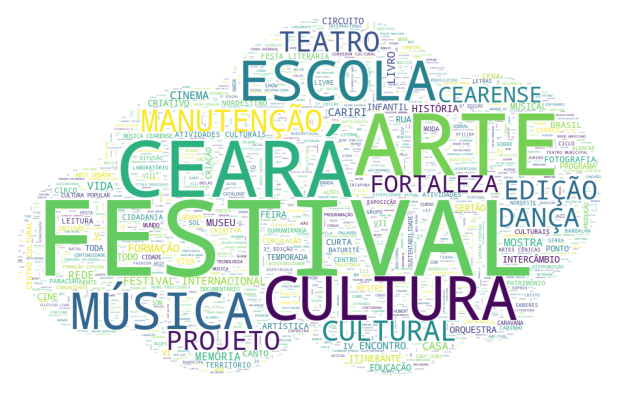

In [62]:
def type_of_project_most_money(d):
    _df_projects = d.groupby(by=['order'])['value'].max()
    _df_projects = _df_projects.sort_values(ascending=False)[0:5]
    _df = d[d['order'].isin(_df_projects.index)]

    _mask = np.array(Image.open("image/cloud.jpg"))
    _wc = WordCloud(stopwords=stopwords_,
                      background_color="white", 
                      width=1500, height=800, max_words=2000,
                      mask=_mask, max_font_size=200,
                      min_font_size=1).generate(get_words(_df))

    fig, ax = plt.subplots(figsize=(13,7))
    ax.imshow(_wc, interpolation='bilinear')
    ax.set_axis_off()
    plt.imshow(_wc)
    
    barchart_word_ranking(_df)

type_of_project_most_money(df_dataset)

## Importações e configurações gerais

In [ ]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', 0)

In [13]:
def notice_year(d, outliers):
    _dates = d[~d['value'].isin(outliers)].groupby(by=['order'])['registration_date_init'].max()
    _years = []
    for date in _dates:
        if date is not np.nan:
            _years.append(int(get_year(date)))
    return _years

In [14]:
def notice_month(d, outliers):
    _dates = d[~d['value'].isin(outliers)].groupby(by=['order'])['registration_date_init'].max()
    _months = []
    for date in _dates:
        if date is not np.nan:
            _months.append(date[3:5])
    return _months

In [16]:
def get_year(d):
    if d is np.nan:
        return ''
    else:
        return d[-4:]

In [17]:
def options():
    _choice = Counter(notice_year(df_dataset, [])).keys()
    _choice = sorted(list(_choice))
    _choice.append('Todos')
    return _choice

In [18]:
choice_ = options()

In [19]:
def filtred_dataset(d, year_filter):
    if (year_filter == "Todos"):
        year_filter = str(choice_[0]) + ' - ' + str(choice_[len(choice_) - 2])
    else:
        d = d[d['year'] == int(year_filter)]
    return d, year_filter

In [20]:
def get_slider_year():
    _slider_year = widgets.SelectionSlider(
        options=choice_,
#         options=['2017', '2018', '2019', '2020', '2021', 'Todos'],
        value='Todos',
        description='Ano:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True
    )
    return _slider_year

In [21]:
# Identificando outliers (com scipy)
def find_outliers_scipy(_data):
    _outl = []
    _d = _data.tolist()
    _z_res = stats.zscore(_d)
    _std_cut = 3
    for i in range(len(_z_res)):
        if np.abs(_z_res[i]) >= _std_cut:
            _outl.append(_d[i])
    return _outl

In [22]:
# Buscando outliers com o método interquartis
def find_outliers_interquartile(_data):
    _outl = []
    _q1, _q3 = np.percentile(_data, [25, 75])
    _amp_interquartile = _q3 - _q1
    _lower_limit = _q1 - (1.5 * _amp_interquartile)
    _upper_limit = _q3 + (1.5 * _amp_interquartile)

#     print('Primeiro quartil: ', _q1)
#     print('Terceiro quartil: ', _q3)
#     print('Amplitude interquatil: ', _amp_interquartile)
#     print('Limite infeior: ', _lower_limit)
#     print('Limite superior: ', _upper_limit)

    _data = _data.sort_values(ascending=True)
    _outl = _data[((_data > _upper_limit) | (_data < _lower_limit))].tolist()
    return _outl

In [23]:
# Identificando outliers (Manual z-score)
def find_outliers_z_score(_data):
    _outl = []
    _std_cut = 3
    _mean = _data.mean()
    _std = _data.std()
    
    for d in _data:
        _z_score = (d - _mean) / _std
        if (np.abs(_z_score) >= _std_cut):
           _outl.append(d)
    return _outl